# 1. Create model & train

In [17]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error


X_train = pd.read_csv('data/X_train_cleaned.csv', index_col='Id')
# X_train = pd.read_csv('data/copied-train.csv', index_col='Id')

# print(f"type(X_train): {type(X_train)}")
# print(f"X_train.shape: {X_train.shape}")
y_train = pd.read_csv('data/y_train.csv')
# print(f"type(y_train): {type(y_train)}")
# print(f"y_train.shape: {y_train.shape}")


lr_model = LinearRegression()
lr_model.fit(X_train, y_train) 
r2_score = lr_model.score(X_train, y_train)
print(f"R² score: {r2_score:.4f}")

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_.flatten()
})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
top_features = feature_importance.sort_values('Abs_Coefficient', ascending=False).head(10)
print(top_features)

print(f"Model type {lr_model.__class__.__name__}")


R² score: 0.9444
           Feature  Coefficient  Abs_Coefficient
40     GarageYrBlt    -0.200800         0.200800
214       Garae_Na    -0.191217         0.191217
28       GrLivArea     0.176142         0.176142
9        YearBuilt     0.139001         0.139001
7      OverallQual     0.134439         0.134439
26        2ndFlrSF     0.112052         0.112052
25        1stFlrSF     0.104175         0.104175
8      OverallCond     0.098740         0.098740
73   MSZog_C (all)    -0.085804         0.085804
22     TotalBsmtSF     0.084993         0.084993
Model type LinearRegression


# 2. test model on train output 


RMSE (log scale): 0.0933
RMSE (actual $): $16716.40
Mean Absolute Percentage Error: 6.71%


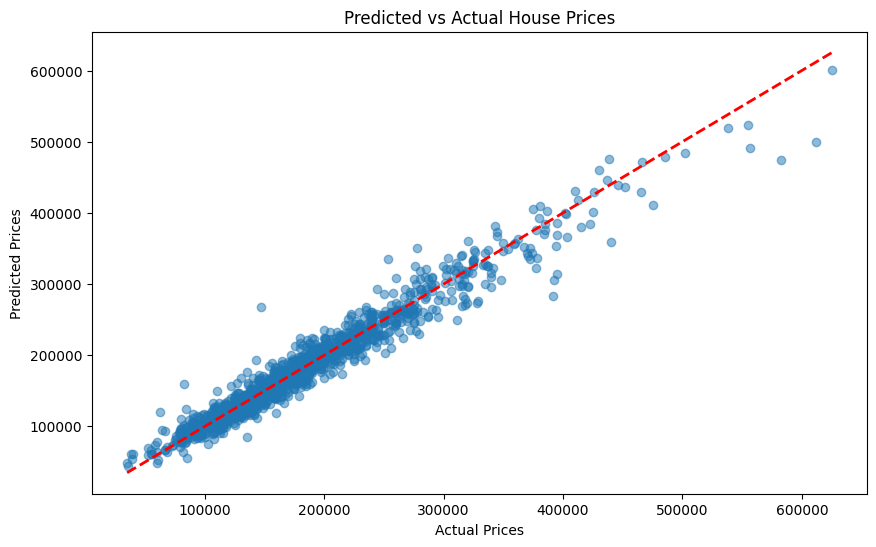

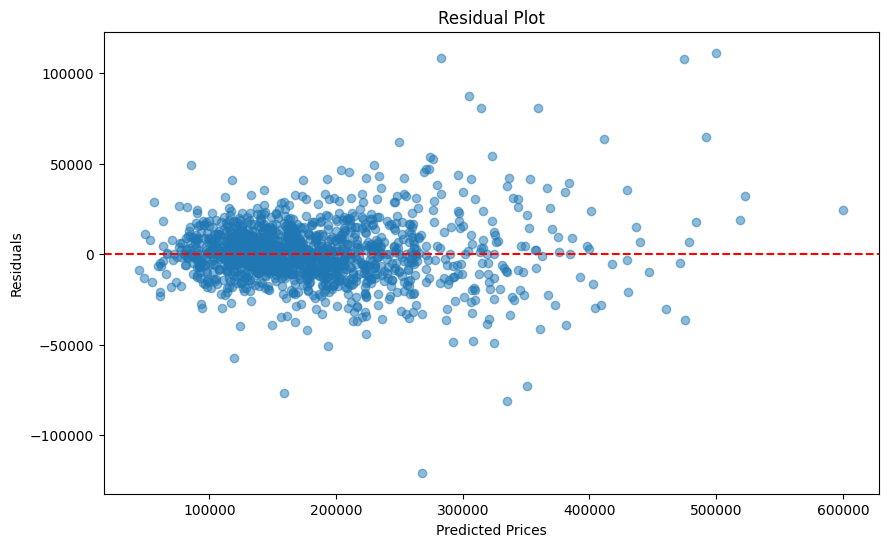

In [5]:
y_pred_log = lr_model.predict(X_train)

rmse_log = np.sqrt(mean_squared_error(y_train, y_pred_log))
print(f"RMSE (log scale): {rmse_log:.4f}")

# Convert predictions back to original price scale
y_train_actual = np.expm1(y_train)
y_pred_actual = np.expm1(y_pred_log)

rmse_actual = np.sqrt(mean_squared_error(y_train_actual, y_pred_actual))
print(f"RMSE (actual $): ${rmse_actual:.2f}")

# Mean Absolute Percentage Error (more interpretable)
mape = np.mean(np.abs((y_train_actual - y_pred_actual) / y_train_actual)) * 100
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_train_actual, y_pred_actual, alpha=0.5)
plt.plot([y_train_actual.min(), y_train_actual.max()], 
         [y_train_actual.min(), y_train_actual.max()], 
         'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual House Prices')
plt.show()

# Optional: Plot residuals to check for patterns
residuals = y_train_actual - y_pred_actual
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_actual, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# 3. Use model & make predictions

In [6]:
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter


test_df = pd.read_csv('data/X_test_cleaned.csv')

predict_prices  = lr_model.predict(test_df).flatten()
# print(predict_prices)
print(f"predict_prices.shape: {predict_prices.shape}")    

predict_prices_actual = np.expm1(predict_prices)
print(f"Example of prices: \n{predict_prices_actual}")

# Check the values
print("Min price:", predict_prices_actual.min())
print("Max price:", predict_prices_actual.max())
print("Mean price:", predict_prices_actual.mean())


# print 

# Format function to convert to $xxx,xxx format
def currency_formatter(x, pos):
    return f'${x:,.0f}'


plt.figure(figsize=(10, 6))
sns.histplot(predict_prices_actual, kde=True)
plt.title('Distribution of Predicted House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
# plt.show()
plt.gca().xaxis.set_major_formatter(FuncFormatter(currency_formatter))
plt.tight_layout()
plt.show()





ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- BldgType_2fmCon
- BldgType_Duplex
- BldgType_Twnhs
- BldgType_TwnhsE
- Condition1_Feedr
- ...
Feature names seen at fit time, yet now missing:
- Bldge_1Fam
- Bldge_2fmCon
- Bldge_Duplex
- Bldge_Twnhs
- Bldge_TwnhsE
- ...


# 4. Create submissional format 

In [22]:
submission_df = pd.DataFrame({
    'Id': test_df.Id,
    'SalePrice': predict_prices_actual
})
submission_df.to_csv('data/submission.csv', index=False)